# Comparing The Small Displacement and Large Displacement Formulations

This notebook is an example comparing the mixed-mode response of two user element subroutines modeling the cohesive zone elements. The following mixed-mode ADCB tests are the tests defined in section 3.2.3 on `Mixed-Mode Tests With Low Modulus Bulk`, presented in the master thesis title `Finite Element Model For Interfaces In Compatibilized Polymer Blends`. 

**Outline**

1) Create design of experiments. $\checkmark$
2) Run simulations. $\checkmark$
3) Read odb data.  $\checkmark$
4) Generate R curves.  $\checkmark$
5) Extract Fracture toughness samples from R curves.  $\checkmark$
6) Predict mode ratio based on the sampled fracture toughness and assumed mixed-mode energy criteria.  $\checkmark$

## Preprocessing

Import required modules.

In [1]:
# imports
import json
import numpy as np
from IPython import display
from scipy.stats import qmc
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

Create a dictionary of the variables required to generate and run the Abaqus/CAE model that are common for all the tests.

In [2]:
TestSet = 'ADCB_UEL' # Folder name for the set of experiments

# Constants for the experiments
fixed = {'JobID':'ADCB_UEL', 
    'Length':50,
    'Width':25,
    'tBot':10,
    'tCz':0.2,
    'Crack':1,
    'DensityBulkTop':1.8e-9,
    'ETop':(5.0, 5.0, 5.0, 0.3, 0.3, 0.3, 5/(2*(1+0.3)), 5/(2*(1+0.3)), 5/(2*(1+0.3))), #(109000.0, 8819.0, 8819.0, 0.34, 0.34, 0.38, 4315.0, 4315.0, 3200.0), 
    'DensityBulkBot':1.8e-9,
    'EBot': (5.0, 5.0, 5.0, 0.3, 0.3, 0.3, 5/(2*(1+0.3)), 5/(2*(1+0.3)), 5/(2*(1+0.3))), #(109000.0, 8819.0, 8819.0, 0.34, 0.34, 0.38, 4315.0, 4315.0, 3200.0),
    'DensityCz':1.8e-9,
    'StiffnessCz':1,
    'GcNormal': 0.1,
    'GcShear':1,
    'gFailureNormal':2,
    'gFailureShear':2,
    'MeshCrack':1,
    'MeshX':1,
    'MeshZ':1,
    'Displacement':20,
    'bkPower':1,
    'nCpu':1,
    'nGpu':0,
    'submit':True}

Further, define the variables that have to be changed for each experiment.

In [3]:
top = [[3], [5], [8]] # Values of interest for the thickness of the upper adherand or bulk
sub = [[{'type':'UEL', 'path':'SDF.for', 'intProp':[]}],
    [{'type':'UEL', 'path':'LDF.for', 'intProp':[]}]] # User subroutines of interest

# Creating lists with all combinations of the two variables
topList = []
subList = []
for i in top:
    for j in sub:
        topList.append(i)
        subList.append(j)
n_pts = len(topList)

# Defining a dictionary with lists of values for the variables.
doe = {'tTop':topList,
    'userSub':subList}
doe['nPoints'] = n_pts

## Running simulations

The `run_sim` function iterates through each point in the design of experiments (doe) and creates an instance of the input data by assigning the values for the variables from their corresponding lists in the `doe` dict along with all the fixed variables. 
For example, in this case, the `i`th instance will be assigned a value of `topList[i]` for the `tTop` variable and `subList[i]` for the `userSub` variable along with all the variables in the `fixed` dict.
Further, for each instance, a folder `point_i` is created and set as working directory. 
Finally, the abaqus python script in `czmtestkit.abaqus_modules.ADCB2` is executed in the working directory with instance input data using the following command.

In [ ]:
from czmtestkit.py_modules import run_sim
run_sim(TestSet, doe, fixed, 'czmtestkit.abaqus_modules.ADCB2')

`czmtestkit.abaqus_modules.ADCB2` creates a unit width CAE model with plain strain conditions and runs the finite element simulation of the model using Abaqus/CAE resulting in `.odb` file with the output database. The history of displacement and reaction force in the active degrees of freedom of the load edge are recorded using the Abaqus/CAE history output functionality and can be extracted from the `.odb` file. `czmtestkit.abaqus_modules.historyOutput` function extracts this data and generates a `.csv` with the data. Further, since `czmtestkit.abaqus_modules.ADCB2` creates a unit width CAE model, the `Results` function returns a dict with the magnitudes of the displacement and reaction force adjusted to required width by multiplying the actual width. `run_sims` can also iteratively run these abaqus post processing and python post processing functions for each instance. The input parameter and output from all the instances are saved to the `Database.json` file in the test directory. 

**Note:** The Abaqus/CAE files for this testset have not been included in the git repository.

In [ ]:
from czmtestkit.py_modules import Results
from czmtestkit.py_modules import run_sim
run_sim(TestSet, doe, fixed, abaqus_postProc='czmtestkit.abaqus_modules.historyOutput',postProc=Results)

Read the database and plot the output data.

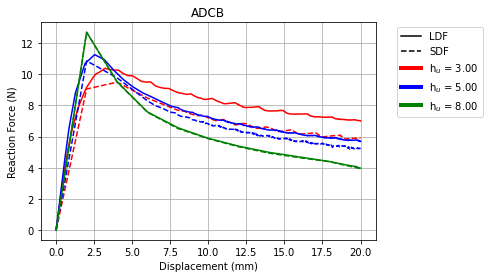

In [4]:
# Reading output file
import os
file = open(os.path.join(TestSet, 'Database.json'), 'r')
data_text = file.readlines()
Data = []
for entry in data_text:
    Data.append(json.loads(entry))

# Extracting output data and input variables
U = []
RF = []
czImp = []
hu = []
for entry in Data:
    U.append(np.array(entry['Displacement']))
    RF.append(np.array(entry['Reaction Force']))
    hu.append(entry['tTop'])
    SubROut = os.path.split(entry['userSub']['path'])[-1].split('.')[0]
    czImp.append(SubROut)

file.close()

# Defining arrays useful for generating plots
ls = []
c = []
cl = []
m = []
for i in range(n_pts):
    if czImp[i]=='LDF':
        ls.append('solid')
        cl.append('r')
    else:
        ls.append('dashed')
        cl.append('b')
    
    if hu[i]==3:
        c.append('r')
        m.append('s')
    elif hu[i]==5:
        c.append('b')
        m.append('d')
    else:
        c.append('g')
        m.append('*')

# Plotting
fig, ax = plt.subplots()
for i in range(n_pts):
    ax.plot(U[i], RF[i], c=c[i], linestyle=ls[i])
ax.set_title('ADCB')
ax.set_xlabel('Displacement (mm)')
ax.set_ylabel('Reaction Force (N)')
plt.grid()
## Custom legend
custom_lines = [Line2D([0], [0], color='black', ls='solid'),
                Line2D([0], [0], color='black', ls='dashed'),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4)]
ax.legend(custom_lines, ['LDF', 'SDF', 'h$_u$ = {:.2f}'.format(3), 'h$_u$ = {:.2f}'.format(5), 'h$_u$ = {:.2f}'.format(8)], bbox_to_anchor=(1.05, 1.0), loc='upper left')



## Post Processing

The class `czmtestkit.py_modules.ADCB` is the analytical models from appendix B in the master thesis title `Finite Element Model For Interfaces In Compatibilized Polymer Blends` and the class method `czmtestkit.py_modules.ADCB.rCurve` converts the displacement and reaction force data to fracture resistance curves (r Curves) for a given instance. The `czmtestkit.py_modules.run_analysis` function iteratively runs the `czmtestkit.py_modules.ADCB.rCurve` method for all the instances (dictionaries) in `Database.json` of the `TestSet` directory and appends the generated r Curve data back to the database.

In [ ]:
from czmtestkit.py_modules import ADCB # Analytical model for the test
from czmtestkit.py_modules import run_analysis # Runs the function all the instance in the doe. 

model = ADCB()
run_analysis(TestSet, model.rCurve)

Read the database and plot the output data.

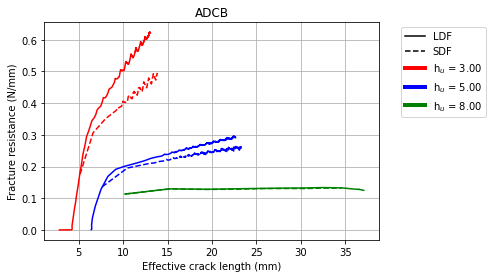

In [5]:
# Reading output file
file = open(os.path.join(TestSet, 'Database.json'), 'r')
data_text = file.readlines()
Data = []
for entry in data_text:
    Data.append(json.loads(entry))

# Extracting output data
a_e = [] # effective crack length
gR = [] # fracture toughness / fracture resistance
for entry in Data:
    a_e.append(np.array(entry['Crack Length']))
    gR.append(np.array(entry['Fracture Resistance']))

file.close()

# Plotting
fig, ax = plt.subplots()
for i in range(n_pts):
    ax.plot(a_e[i], gR[i], c=c[i], linestyle=ls[i])
plt.grid()
ax.set_title('ADCB')
ax.set_xlabel('Effective crack length (mm)')
ax.set_ylabel('Fracture resistance (N/mm)')
## Custom legend
custom_lines = [Line2D([0], [0], color='black', ls='solid'),
                Line2D([0], [0], color='black', ls='dashed'),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4)]
ax.legend(custom_lines, ['LDF', 'SDF', 'h$_u$ = {:.2f}'.format(3), 'h$_u$ = {:.2f}'.format(5), 'h$_u$ = {:.2f}'.format(8)], bbox_to_anchor=(1.05, 1.0), loc='upper left')

Sample the plateaus in the r Curves for fracture toughness estimation and plot the sample statistics (mean and confidence intervals).

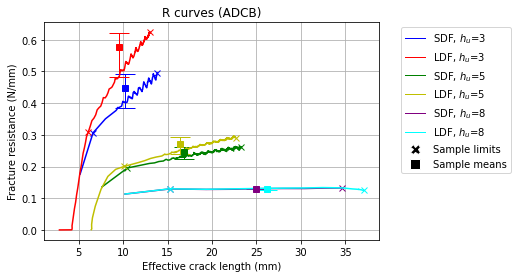

In [10]:
# defining the plateau region
a_l = [6,6,10,10,15,15] # Crack length at plateau start
a_u = [40,40,40,40,40,40] # Crack length at plateau end

# picking samples and calculating the sample statistics
## Initializing empty vectors
g_sample = []
alim_sample = []
glim_sample = []
Gt = []
CI = []

## Iterating through the tests
for i in range(n_pts):
    ind = np.where(np.logical_and(a_e[i]>=a_l[i], a_e[i]<=a_u[i])) # Fetching samples with crack length within the limits choosen
    g_sample.append(gR[i][ind[0].tolist()]) # Sampling fracture tougness corresponding to the sampled crack lengths
    alim_sample.append(np.array([a_e[i][ind[0][0]], a_e[i][ind[0][-1]]])) # Crack length sample limits
    glim_sample.append(np.array([gR[i][ind[0][0]], gR[i][ind[0][-1]]])) # Fracture toughness sample limits
    mean = g_sample[i].mean() # Fracture toughness sample mean
    p025 = np.percentile(g_sample[i], 2.5) # Fracture toughness lower quartile
    p975 = np.percentile(g_sample[i], 97.5) # Fracture toughness upper quartile
    Gt.append(mean) # Appending to list of means of all the tests
    CI.append([[mean - p025], [p975 - mean]]) # Appending to list of confidence intervals of all the tests

# Plotting the r-Curve with fracture toughness samples and statistics
C = ['b', 'r', 'g', 'y', 'purple', 'cyan'] # List of colors for plotting
Lab = [] # List of labels for custom legend
custom_lines = [] # List of keys for custom legend
fig, ax = plt.subplots() # Empty figure

## Iterating through Tests and plotting data
for i in range(n_pts):
    custom_lines.append(Line2D([0], [0], color=C[i], lw=1))
    Lab.append(czImp[i]+', $h_u$={}'.format(hu[i]))
    plt.plot(a_e[i], gR[i], color=C[i])
    plt.plot(alim_sample[i], glim_sample[i], 'x', color=C[i])
    plt.errorbar(alim_sample[i].mean(), Gt[i], yerr=CI[i], fmt = 's', color=C[i], ecolor=C[i], elinewidth = 1, capsize=10) #label='Mean: \u03B7 = {:.3f}'.format(eta[i])

## Custom legend
custom_lines.append(Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=10))
Lab.append('Sample limits')
custom_lines.append(Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=10))
Lab.append('Sample means')
ax.legend(custom_lines, Lab, bbox_to_anchor=(1.05, 1.0), loc='upper left')

## Plot area steup
plt.xlabel('Effective crack length (mm)')
plt.ylabel('Fracture resistance (N/mm)')
plt.title('R curves (ADCB)')
plt.grid()
plt.show()

Since, the BK criterion was used to in the Abaqus/CAE model, the same is used to estimate a mode ratio for each estimated fracture toughness.

In [8]:
def BK_criteria(gT, GIc, GIIc, eta):
    return ((gT - GIc)/(GIIc - GIc))**(1/eta)

The fracture toughness for one instance of the doe is a list of values sampled from its r Curve. Predicting the mode ratio for this list results in a list of predicted mode ratios for the instance. The means and confidence intervals of the lists of predicted mode ratios and the fracture toughness for each instance of the test are plotted here.

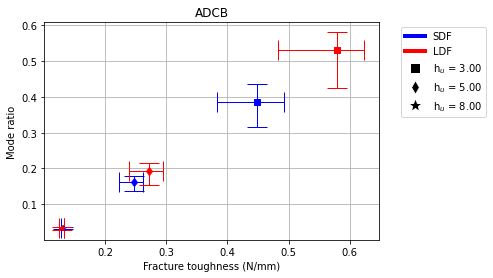

In [11]:
# Initializing empty vectors
B = []
CI_B = []
fig, ax = plt.subplots() # Empty figure


# Predicting and plotting mode ratios corresponding to the fracture toughness samples
for i in range(n_pts):
    b = BK_criteria(g_sample[i], fixed['GcNormal'], fixed['GcShear'], fixed['bkPower']) #Predicting mode ratios
    mean = b.mean() # Mean of predicted mode ratios
    p025 = np.percentile(b, 2.5) # lower quartile mode ratios
    p975 = np.percentile(b, 97.5) # upper quartile mode ratios
    B.append(mean) # mean mpde ratio
    CI_B.append([[mean - p025], [p975 - mean]]) # 95% confidence intervals of mode predicted mode ratios
    plt.errorbar(Gt[i], B[i], xerr=CI[i], yerr=CI_B[i], fmt = m[i], color=cl[i], ecolor=cl[i], elinewidth = 1, capsize=10)

## Custom legend
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], marker=m[0], color='w', markerfacecolor='black', markersize=10),
                Line2D([0], [0], marker=m[2], color='w', markerfacecolor='black', markersize=10),
                Line2D([0], [0], marker=m[4], color='w', markerfacecolor='black', markersize=15)]
ax.legend(custom_lines, ['SDF', 'LDF', 'h$_u$ = {:.2f}'.format(hu[0]), 'h$_u$ = {:.2f}'.format(hu[2]), 'h$_u$ = {:.2f}'.format(hu[4])], bbox_to_anchor=(1.05, 1.0), loc='upper left')

## Plot area steup
plt.xlabel('Fracture toughness (N/mm)')
plt.ylabel('Mode ratio')
plt.title('ADCB')
plt.grid()
plt.show()